In [1]:
import numpy as np
from scipy.stats import randint
import pandas as pd
from IPython.core.display_functions import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from helper import *
import graphviz
from IPython.display import Image
from IPython.display import display
from sklearn.tree import export_graphviz
import seaborn as sns
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from helper import *
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Supress all warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Random Forest

**Random Forest Methods**

In [2]:
def random_forest(X_, Y_, tune_hyperparameters=True, n_folds=5):
    """
    Constructs multiple decision trees during training time and outputs the class
    that is the mode of the classes of the individual trees

    Adapted from:
    https://www.datacamp.com/tutorial/random-forests-classifier-python
    :param X_: Training set features
    :param Y_: Training set labels
    :param tune_hyperparameters: Whether to tune the hyperparameters
    :param n_folds: Number of folds for cross-validation
    :return:
    """

    # Hyperparameter tuning
    param_dist = {
        # Number of decision trees in the forest.
        # Generally, the higher, the better performance but it increases the computation cost
        'n_estimators': randint(200, 500),
        # The maximum depth of each tree in the forest
        # Higher values could lead to overfitting, while lower values could lead to underfitting
        'max_depth': range(2, 10),
        # The minimum number of samples required to split an internal node
        'min_samples_split': range(3, 10),
        # The minimum number of samples required to be at a leaf node
        'min_samples_leaf': range(1, 5),
        # The number of features to consider when looking for the best split
        'max_features': ["sqrt", "log2"],
        # The function to measure the quality of a split
        'criterion': ["gini", "entropy"]
    }

    if tune_hyperparameters:
        rf = RandomForestClassifier(random_state=42, bootstrap=True)
        # Perform randomized search on hyperparameters with n-fold cross-validation
        rand_search = RandomizedSearchCV(
            estimator=rf, param_distributions=param_dist, n_iter=10, cv=n_folds,
            random_state=42, n_jobs=-1, verbose=2, scoring='precision'
        )
        # Fit the model to the training data
        print(np.unique(Y_))
        rand_search.fit(X_, Y_)

        # Best parameters
        best_params = rand_search.best_params_
        for param_name in sorted(best_params.keys()):
            print(f"{param_name}: {best_params[param_name]}")

        # Return the best model
        return rand_search.best_estimator_

    else:
        rf = RandomForestClassifier(
            random_state=42, bootstrap=True,
            n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=5,
            max_features="sqrt", class_weight="balanced")
        
        # Fit the model to the entire training data
        rf.fit(X_, Y_)
        
        return rf

**Plotting Methods**

In [3]:
def plot_decision_trees(feature_names, rf_, num_trees=2):
    """
    Plot the decision trees of the random forest
    :param feature_names: Names of the features
    :param rf_: Random forest model
    :param num_trees: Number of trees to plot
    """
    
    for i in range(num_trees):
        tree = rf_.estimators_[i]
        dot_data = export_graphviz(
            tree,
            feature_names=feature_names,
            class_names=["Stable", "Slow Decliner", "Fast Decliner"],
            filled=True, rounded=True,
            max_depth=5,
            impurity=False,
            proportion=True,
            out_file=None,  
        )
        graph = graphviz.Source(dot_data, directory="trees")
        graph.render(f'tree_{i}', format='png')
        display(Image(filename=f'trees/tree_{i}.png'))

### Read Data

In [4]:
# Load the dataset
path = "C:/Users/mjgoj/Desktop/THESIS/data/final_dataset_split.xls"
xls = pd.ExcelFile(path)

lipidomics = pd.read_excel(xls, "Lipidomics")
metabolomics = pd.read_excel(xls, "Pareto Metabolomics")
# metabolomics = pd.read_excel(xls, "Metabolomics")
proteomics = pd.read_excel(xls, "Pareto Proteomics")
# proteomics = pd.read_excel(xls, "Proteomics")

X_train, X_test, Y_train, y_test = concatenate_data(lipidomics, metabolomics, proteomics)
class_mapping = {
    1 : 0,
    2 : 1,
    3 : 2
}
Y_train = Y_train.map(class_mapping)
y_test = y_test.map(class_mapping)
X_train_resampled, Y_train_resampled = resampling(X_train, Y_train)

Training set shape:  (58, 1118)
Testing set shape:  (38, 1118)
Resampled set shape: 
(99, 1111)
(99,)
Resampled set class distribution: 
 0    33
1    33
2    33
Name: ThreeClass, dtype: int64


## Training of the Random Forest Model

### Training with resampling and Hyperparameter tuning

[0 1 2]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
criterion: gini
max_depth: 5
max_features: sqrt
min_samples_leaf: 3
min_samples_split: 5
n_estimators: 271

Accuracy of the model: 0.5263157894736842
Recall of the model: 0.5263157894736842
Precision of the model: 0.39932088285229206
F1 Score of the model: 0.45066353705877044


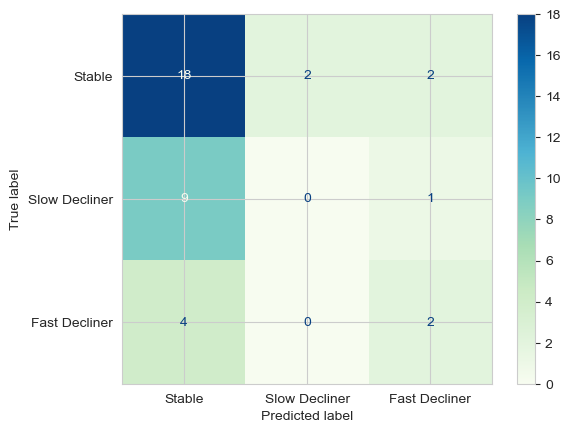

In [5]:
rf_resampling_tuning = random_forest(X_train_resampled, Y_train_resampled, True)

# Check the accuracy of the model
y_prediction = rf_resampling_tuning.predict(X_test)
evaluate_model(y_prediction, y_test)

### 3) Training with resampling and NO Hyperparameter tuning


Accuracy of the model: 0.5
Recall of the model: 0.5
Precision of the model: 0.38070175438596493
F1 Score of the model: 0.431174089068826


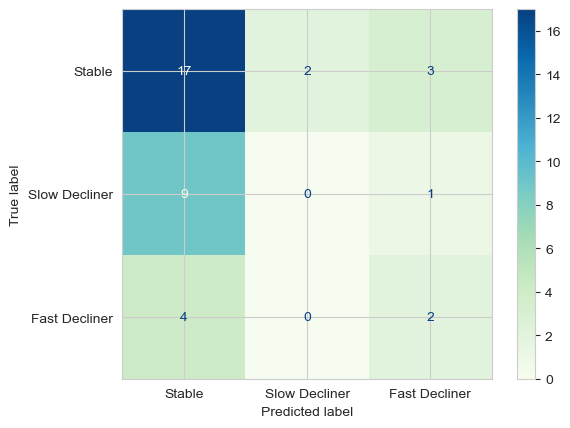

In [6]:
rf_resampling_tuning = random_forest(X_train_resampled, Y_train_resampled, False, 10)

# Check the accuracy of the model
y_prediction = rf_resampling_tuning.predict(X_test)
evaluate_model(y_prediction, y_test)

Distribution of the classes in the test set

0    22
1    10
2     6
Name: ThreeClass, dtype: int64


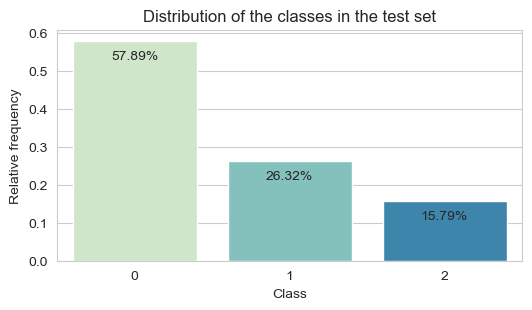

In [7]:
# Plot distribution of the Y variable
y_test_count = y_test.value_counts()
print(y_test_count)
y_test_count = y_test_count / y_test_count.sum()
plt.figure(figsize=(6, 3))
sns.barplot(x=y_test_count.index, y=y_test_count.values, palette="GnBu")
plt.title("Distribution of the classes in the test set")
plt.ylabel("Relative frequency")

plt.xlabel("Class")
for i in range(len(y_test_count)):
    plt.text(
        x=i, y=y_test_count.values[i] - 0.05,
        s=f"{y_test_count.values[i]*100:.2f}%", ha="center",)
plt.show()

# (*) Decision Tree on the constrained number of features


In [8]:
lipidomics_features = [
    'LPE_22_6_SN1_', 'PC_16_0_18_3_B_', 'PC_33_0_B_',
    'LPC_18_2_SN2_', 'DHCER_D18_0_20_0_',
    'RID', 'ThreeClass'
]
lipidomics_filtered = lipidomics[lipidomics_features]

metabolomics_features = [
    'APOB.APOA1', 'M.LDL.CE_.', 'REMNANT.C',
    'XL.VLDL.FC', 'XS.VLDL.FC',
    'RID', 'ThreeClass'
]
metabolomics_filtered = metabolomics[metabolomics_features]

proteomics_features = [
    'EVAFDLEIPK', 'HLSLLTTLSNR', 'LSITGTYDLK',
    'YIVSGTPTFVPYLIK', 'LSILYPATTGR', 
    'RID', 'ThreeClass'
]
proteomics_filtered = proteomics[proteomics_features]

X_train_filtered, X_test_filtered, Y_train_filtered, Y_test_filtered = concatenate_data(
    lipidomics_filtered, metabolomics_filtered, proteomics_filtered
)
class_mapping = {
    1 : 0,
    2 : 1,
    3 : 2
}
Y_train_filtered = Y_train_filtered.map(class_mapping)
Y_test_filtered = Y_test_filtered.map(class_mapping)
print(np.unique(Y_train_filtered))

Training set shape:  (58, 19)
Testing set shape:  (38, 19)
[0 1 2]



Accuracy of the model: 0.5263157894736842
Recall of the model: 0.5263157894736842
Precision of the model: 0.6543062200956937
F1 Score of the model: 0.5832438238453276


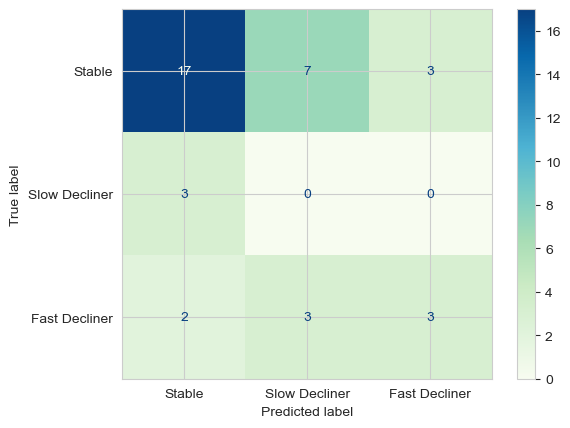

In [9]:
rf_filtered = random_forest(X_train_filtered, Y_train_filtered, False)
# Check the accuracy of the model
y_prediction = rf_filtered.predict(X_test_filtered)
evaluate_model(Y_test_filtered, y_prediction)

# 2. XG Boost (eXtreme Gradient Boosting)

XG Boost model identifies the errors of the existing ensemble of trees by using the gradient of the loss function (which measures the difference between the predicted and actual outcomes). 
New trees are then added to reduce the loss function, focusing on correcting the errors of the previous trees.

XGBoost includes a regularization term in its objective function, which helps to control overfitting. This is a key difference from traditional gradient boosting methods, making XGBoost more powerful and effective.

[tutorial link](https://gist.github.com/alinaselega/a85a41b733c0eed1d5c607fad0cddc17)

[Avoiding Overfitting](https://stats.stackexchange.com/questions/443259/how-to-avoid-overfitting-in-xgboost-model)

[Hyperparameter Tuning](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html)

In [10]:
# Get distribution of classes in the training set
Y_train_resampled.value_counts()

# Resample testing dataset
x_test_resampled, y_test_resampled = resampling(X_test, y_test)

Resampled set shape: 
(66, 1111)
(66,)
Resampled set class distribution: 
 1    22
0    22
2    22
Name: ThreeClass, dtype: int64


## Hyperparameter Tuning for XGBoost
This takes a while to run

In [11]:
boost_model = xgb.XGBClassifier(
    objective='multi:softprob'
)
parameters = {
    # Learning rate
    "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25],
    # Maximum depth of the tree
     "max_depth"        : [2, 3, 4, 5, 6, 8],
    # Minimum sum of instance weight (hessian) needed in a child
    "min_child_weight" : [3, 5, 7 ],
    # The fraction of samples to be used for fitting the individual base learners
     "gamma"            : [0.2 , 0.3, 0.4],
    # The fraction of features to be randomly samples for each tree
     "colsample_bytree" : [ 0.3, 0.4, 0.7 ],
    # The number of trees
     "n_estimators"     : [10, 20]
     }

grid = GridSearchCV(boost_model, parameters, n_jobs=4, cv=3)
grid.fit(X_train_resampled, Y_train_resampled)
print(grid.best_params_)


KeyboardInterrupt



In [ ]:
prediction_test = grid.predict(x_test_resampled)
accuracy = accuracy_score(y_test_resampled, prediction_test)
print("\nAccuracy of the XGBoost model: {}".format(accuracy))

plot_confusion_matrix(y_test_resampled, prediction_test)

In [ ]:
top_feature_num = 20
xgb.plot_importance(grid.best_estimator_, max_num_features=top_feature_num)
plt.title('Feature Importance')
plt.show()

### Custom Model

In [12]:
custom_boost_model = xgb.XGBClassifier(
    objective='multi:softprob',
    
    # Control model complexity to prevent overfitting
    max_depth=4, # default=6
    min_child_weight=3, # default=1
    gamma=0.2, # default=0
    
    # Add randomness to make training robust to noise
    colsample_bytree=0.3, # default=1 (Subsample ratio of columns when constructing each tree)
    subsample=0.7, # default=1 (Subsample ratio of the training instances)
    eta=0.1, # default=0.3 (Learning rate)
    num_round=500 # default=100 (Number of boosting rounds)
)

custom_boost_model.fit(X_train_resampled, Y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy of the XGBoost model:     0.3939
Recall of the XGBoost model:     0.3939
Precision of the XGBoost model:     0.5302
F1 Score of the XGBoost model:     0.3452


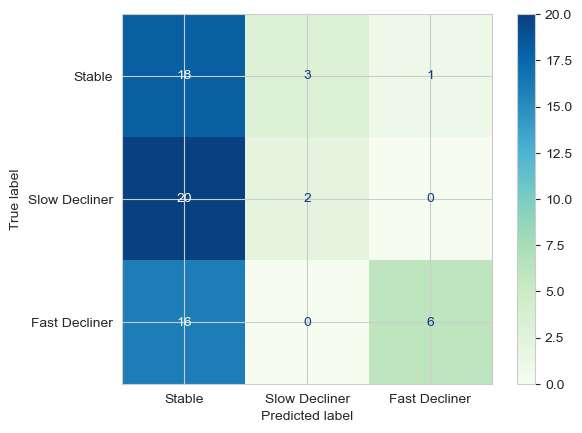

In [13]:
# Check the accuracy of the model
y_prediction = custom_boost_model.predict(x_test_resampled)

accuracy = accuracy_score(y_test_resampled, y_prediction)
recall = recall_score(y_test_resampled, y_prediction, average='weighted')
precision = precision_score(y_test_resampled, y_prediction, average='weighted')
f1 = f1_score(y_test_resampled, y_prediction, average='weighted')

print("Accuracy of the XGBoost model: {0:10.4f}".format(accuracy))
print("Recall of the XGBoost model: {0:10.4f}".format(recall))
print("Precision of the XGBoost model: {0:10.4f}".format(precision))
print("F1 Score of the XGBoost model: {0:10.4f}".format(f1))

plot_confusion_matrix(y_test_resampled, y_prediction)

# And now - Binary Classification!!!

## 1. Reading the data

Training set shape:  (58, 1118)
Testing set shape:  (38, 1118)


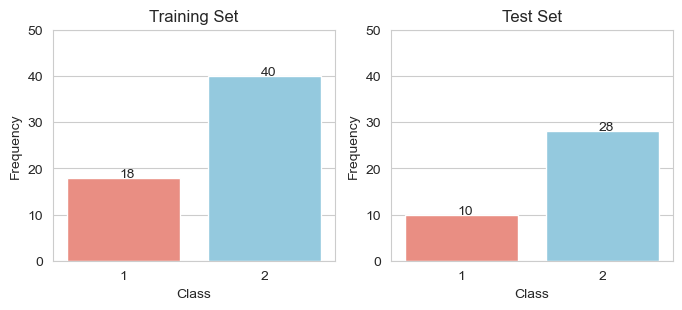

In [14]:
# Load the binary dataset
X_train, X_test, Y_train, y_test = concatenate_data(
    lipidomics, metabolomics, proteomics, num_classes=2)

# Create a plot of the distribution of the classes in the training set
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
colors = ['salmon', 'skyblue']

Y_train_count, y_test_count = Y_train.value_counts(), y_test.value_counts()
y_lim = max(Y_train_count.max(), y_test_count.max()) + 10

# Add the count of each class on top of the bars
sns.barplot(x=Y_train_count.index, y=Y_train_count.values, ax=axs[0], palette=colors)
for p, label in zip(axs[0].patches, Y_train_count.values[::-1]):
    axs[0].annotate(label, (p.get_x()+0.375, p.get_height()+0.15))
axs[0].set_title("Training Set")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Frequency")
axs[0].set_ylim(0, y_lim)

sns.barplot(x=y_test_count.index, y=y_test_count.values, ax=axs[1], palette=colors)
for p, label in zip(axs[1].patches, y_test_count.values[::-1]):
    axs[1].annotate(label, (p.get_x()+0.375, p.get_height()+0.15))

axs[1].set_title("Test Set")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Frequency")
axs[1].set_ylim(0, y_lim)
plt.show()


Add a mapping for the classes

In [15]:
class_mapping = {1 : 0, 2 : 1}
# Mapping the classes
Y_train = Y_train.map(class_mapping)
y_test = y_test.map(class_mapping)
print(np.unique(Y_train))
print(np.unique(y_test))

# Check for nan values
print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

[0 1]
[0 1]
0
0


## 2. Training the Forest Model


Accuracy of the model: 0.7631578947368421
Recall of the model: 0.7631578947368421
Precision of the model: 0.7384370015948963
F1 Score of the model: 0.7333908541846419


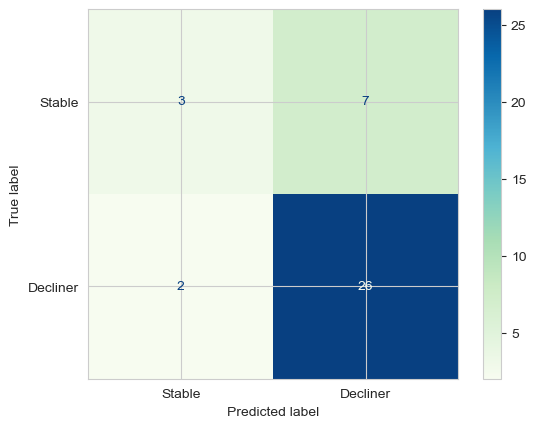

In [18]:
rf_binary = random_forest(X_train, Y_train, False)

# Check the accuracy of the model
y_prediction = rf_binary.predict(X_test)
evaluate_model(y_prediction, y_test)
